**Introduction**

The weakest link of any cybersecurity setup today is often the human one, and any algorithmic assistance that can be rendered to help distinguish between safe and dangerous emails enhances overall cybersecurity. Because the point of storing information is the intention to retrieve it later, the one consistent lever attackers can pull is on the coattails of people with legitimate access. This weakness is not something that can be patched away completely, and exploits utilizing the credentials of legitimate users often comes though emails, often refered to as phishing emails.
By exploiting the human mind's tendency to create mental shortcuts when doing routine tasks like reading emails, phishing emails can trick users into using their elevated privileges on a computer or a network to allow the attacker access the same sensitive information. With language models becoming better to write more natural-sounding emails, users' abilities to distinguish a suspicious email are diminished. In light of that, the best way to protect a user from these emails is to never let it get to them in the first place by blocking through spam filters. However, the filters must get better in response to improved attackers, just another cycle of the arms race between attackers and defenders in the cybersecurity space. Without improvements, every entity dealing with sensitive information becomes that much less safe. 

Enter new technologies, such as machine learning and artificial intelligence that can generate natural sounding language with little effort, and in turn degrade the ability of email recipients to distinguish between safe and phishing emails. However, machine learning is a tool, and tools can be turned many different purposes, perhaps even in defense against more sophisticated phishing emails.

The objective of this project is to identify phishing-like emails in a group of mixed emails and which models are worth exploring in evaluating potentially dangerous emails. Data is from the following Kaggle dataset: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset

In [3]:
import pandas as pd
import nltk
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score

In [4]:
df_ceas = pd.read_csv('archive/CEAS_08.csv')

In [5]:
df_ceas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


Due to having little relevence, the date and receiver columns will be dropped. The prevalance of formerly-legitimate and abandoned accounts being hijacked to send dangerous emails also means the exact identity of the sender is irrelevant.

In [7]:
df = df_ceas.drop(columns = ['date','sender','receiver']).dropna() #intuitively, date has no predictive value on the safety of an email, and neither does receiver

In [8]:
df.head()

,subject,body,label,urls
0,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


After dropping entries with null data, the final dataframe has 39153 rows and 4 columns. The 'label' column is the target column to be predicted based on other columns, where '1' means the email is dangerous and '0' means it is safe.

**Data Exploration**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39126 entries, 0 to 39153
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  39126 non-null  object
 1   body     39126 non-null  object
 2   label    39126 non-null  int64 
 3   urls     39126 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


A deeper look into the data reveals that most of the emails are marked as phishing emails. 

Text(0.5, 0, 'Email Type')

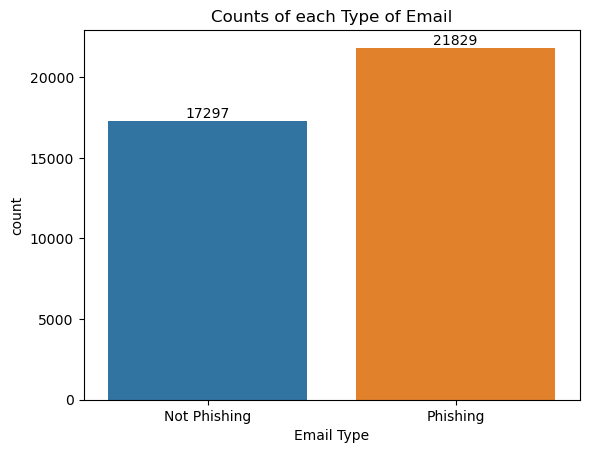

In [13]:
df['urls'] = df['urls'].astype(str)
ax = sns.countplot(data = df, x = 'label')
ax.bar_label(ax.containers[0]);
ax.set_title('Counts of each Type of Email')
plt.xticks(ticks=[0, 1], labels=['Not Phishing', 'Phishing'])
plt.xlabel("Email Type")

**Links and Sign Ins**

A tactic phishing emails sometimes use is to ask the user to login at a particular link, which leads the user to a website that looks like the official website the email is pretending to be from. The user then enters their credentials and the attacker obtains both. As such, any emails that have a link or ask a user to sign in somewhere should receive heightened attention.

The below plot shows the presence of an URL does not seem to indicate a much more risky email than not.

Text(0.5, 0, 'Email Type')

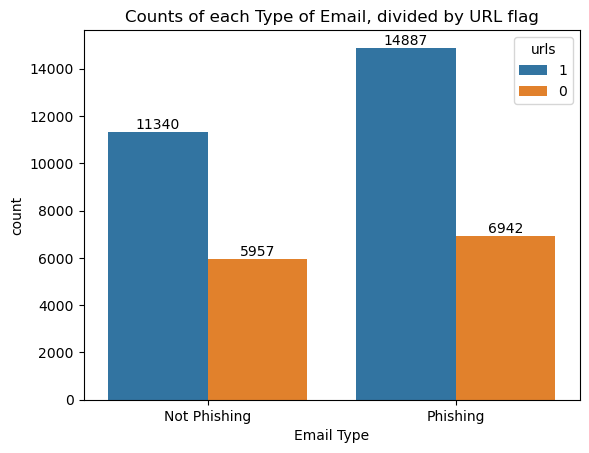

In [15]:
df['urls'] = df['urls'].astype(str)
ax = sns.countplot(data = df, x = 'label',hue = 'urls')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title('Counts of each Type of Email, divided by URL flag')
plt.xticks(ticks=[0, 1], labels=['Not Phishing', 'Phishing'])
plt.xlabel("Email Type")

Same plot for 'sign in.' It was found that "sign in" alone gave better results than any combination of itself and other phrases such as "log in," but despite that, it still remained a tiny presence amongst all the other emails.

In [17]:
keywordlogin = ['sign in']
pattern = '|'.join(keywordlogin)
df['signin'] = df.body.str.contains(pattern).astype(str)

Text(0.5, 0, 'Email Type')

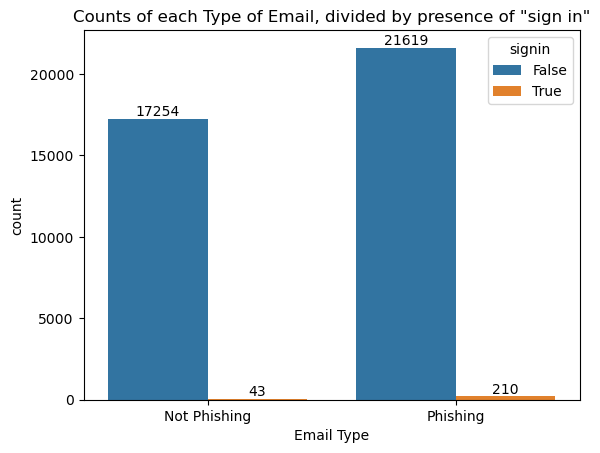

In [18]:
ax = sns.countplot(data = df, x = 'label',hue = 'signin')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title('Counts of each Type of Email, divided by presence of \"sign in\"')
plt.xticks(ticks=[0, 1], labels=['Not Phishing', 'Phishing'])
plt.xlabel("Email Type")

Text(0.5, 0, 'Email Type')

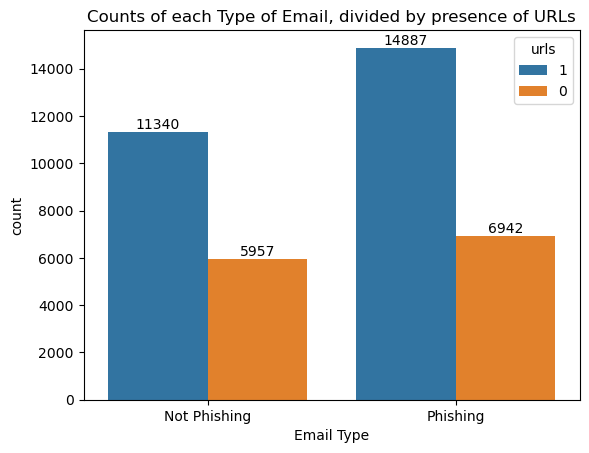

In [19]:
ax = sns.countplot(data = df, x = 'label',hue = 'urls')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title('Counts of each Type of Email, divided by presence of URLs')
plt.xticks(ticks=[0, 1], labels=['Not Phishing', 'Phishing'])
plt.xlabel("Email Type")

**Message Length**

Phishing emails also tend to be shorter to give the reader less time to really consider whether it is legitimate or not, so message length is another metric that can be explored:

In [21]:
df['length'] = df.apply(lambda x: len(x['body']),axis=1)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Email Lengths')

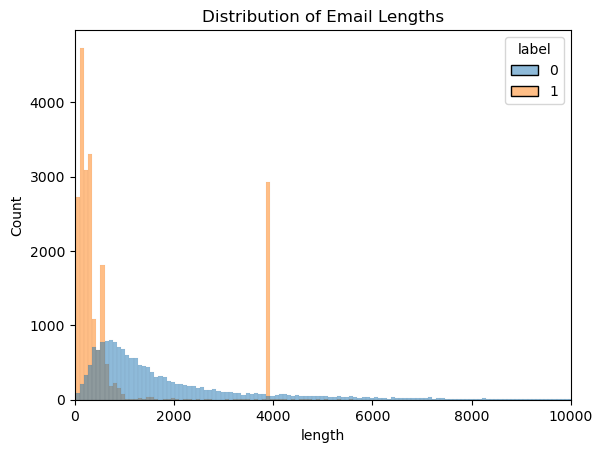

In [22]:
fig, ax = plt.subplots()
sns.histplot(data = df, x = 'length',hue='label')
ax.set_xlim(0, 10000)
ax.set_title("Distribution of Email Lengths")

As it turns out, shorter messages are indeed more dangerous than longer ones in this dataset.

**Data Processing**

To make the data suitable for models to use, the message body in particular must be tokenized and reduced to root forms.

In [25]:
#lemmetize, stemmer
def stemmer(text):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(w) for w in nltk.word_tokenize(text)])

In [26]:
start = time.time()
stemmed_content = df['body'].apply(stemmer)
end = time.time()
print(end-start)

141.0365481376648


In [27]:
cvect = CountVectorizer(stop_words = 'english',max_features = 500)
dtm = cvect.fit_transform(stemmed_content)

The additional features from metadata must also be added:

In [29]:
X = hstack((dtm,np.array(df['length'])[:,None])).tocsr() # 
X = hstack((X,np.array(df['urls'].astype('int64'))[:,None])).tocsr()

y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [30]:
pd.DataFrame(X.toarray(), columns = np.append(cvect.get_feature_names_out(),['length','urls'])).head()

,00,000,01,02,03,04,05,06,07,08,...,workshop,world,write,wrote,www,yahoo,ye,year,length,urls
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,273,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,82,1
2,0,0,16,0,0,0,0,0,4,16,...,0,5,0,0,23,0,0,0,3918,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,376,0,2,0,24418,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,175,1


**Model Training**

Logistic Regression, Decision Tree, Naive Bayes, and Random Forest will be tried on the above dataset. Because the data has a roughly equal amount of dangerous and safe emails, it is safe to use default accuracy as the metric, though final evaluations will still be done in F1 scores, which are more tolerant of unbalanced classes.

**Logistic Regression**

In [32]:
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [0.1,1,10]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
lr_grid = GridSearchCV(estimator=model, param_grid=grid)
start = time.time()
lr_result = lr_grid.fit(X_train, y_train)
end = time.time()
test_acc = lr_result.score(X_test,y_test)

In [33]:
print("Best: %f using %s" % (lr_result.best_score_, lr_result.best_params_))
lr_score = lr_result.score(X_test,y_test)
lr_train_score = lr_result.score(X_train,y_train)
lr_time = end- start
print("Test set Accuracy: ", lr_score)
print("Training set Accuracy: ",lr_train_score)
print(lr_time, "seconds")

Best: 0.984937 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Test set Accuracy:  0.9842567982007769
Training set Accuracy:  0.9904580152671756
36.051655769348145 seconds


Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

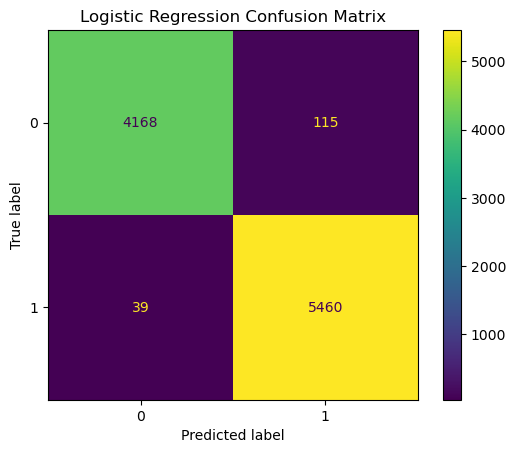

In [34]:
lr_preds = lr_result.best_estimator_.predict(X_test)
lr_f1 = f1_score(y_test,lr_preds)
ConfusionMatrixDisplay(confusion_matrix(y_test, lr_preds)).plot()
plt.grid(False)
plt.title("Logistic Regression Confusion Matrix")

Only allowing 39 dangerous emails and blocking 115 safe emails in about 10,000 emails is quite impressive.

**DecisionTree Classifier**

The next model considered is the DecisionTreeClassifier. Unlike the other models, the best accuracy can intuitively be obtained by not limiting max_depth, but there is some danger of overfitting doing so.

In [37]:
model = DecisionTreeClassifier()
min_samples_split = [4,6,8]
max_depth = [26,28,30,None]
grid = dict(min_samples_split=min_samples_split,max_depth=max_depth)
dec_grid = GridSearchCV(estimator=model, param_grid=grid) 
start = time.time()
dec_result = dec_grid.fit(X_train, y_train)
end = time.time()

In [38]:
print("Best: %f using %s" % (dec_result.best_score_, dec_result.best_params_))
dt_score = dec_result.score(X_test,y_test)
dt_train_score = dec_result.score(X_train,y_train)
dt_time = end - start
print("Test set Accuracy: ", dt_score)
print("Training set Accuracy: ",dt_train_score)
print(dt_time)

Best: 0.980234 using {'max_depth': None, 'min_samples_split': 4}
Test set Accuracy:  0.98108771212431
Training set Accuracy:  0.9984664667393675
48.09818387031555


Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

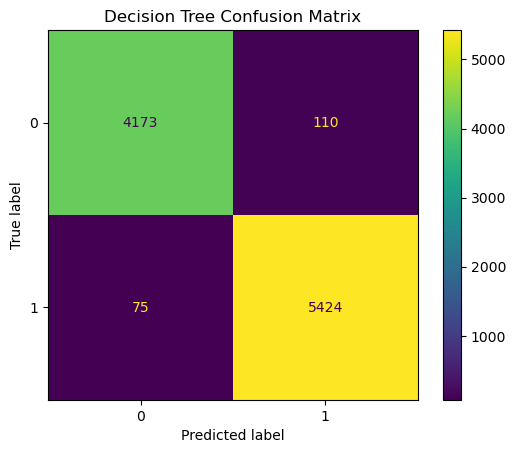

In [39]:
tree_preds = dec_result.best_estimator_.predict(X_test)
tree_f1 = f1_score(y_test,tree_preds)
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_preds)).plot()
plt.grid(False)
plt.title("Decision Tree Confusion Matrix")

With only allowing 69 dangerous emails through and blocking 120 safe emails in about 10,000 emails in the test data, it seems that overfitting did not seem to be an issue.

**Naive Bayes**

In [42]:
model = MultinomialNB()
alphas = [0.001,0.01,0.1,1,10,100,1000,10_000]
grid = dict(alpha=alphas)
by_grid = GridSearchCV(estimator=model, param_grid=grid)
start = time.time()
by_result = by_grid.fit(X_train, y_train)
end = time.time()

In [43]:
#by_preds = by_result.best_estimator_.predict(X_test)
print("Best: %f using %s" % (by_result.best_score_, by_result.best_params_))
by_score = by_result.score(X_test,y_test)
by_train_score = by_result.score(X_train,y_train)
by_time = end-start
print("Test set Accuracy: ", by_score)
print("Training set Accuracy: ",by_train_score)
print(by_time, "seconds")

Best: 0.727406 using {'alpha': 1}
Test set Accuracy:  0.7331833980781026
Training set Accuracy:  0.7273718647764449
0.5366010665893555 seconds


Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

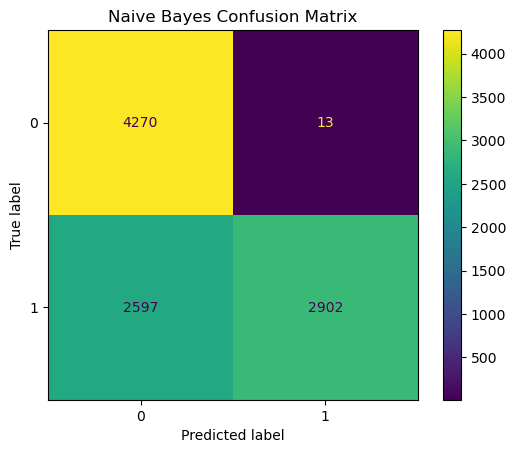

In [44]:
by_preds = by_result.best_estimator_.predict(X_test)
by_f1 = f1_score(y_test,by_preds)
ConfusionMatrixDisplay(confusion_matrix(y_test, by_preds)).plot()
plt.grid(False)
plt.title("Naive Bayes Confusion Matrix")

Naive Bayes performed much worse than the previous 2 models, allowing 2597 dangerous emails through, which is particularly concerning. Overall, it was much more lenient, blocking only 13 safe emails, although it must be noted various improvements could have been made to the data. Because of how Naive Bayes works on frequency of words, any word that does not appear in a dangerous email in the training set will automatically mark an email as safe, so the data could have salted by incrementing all words counts for each email by 1 to make sure the model does not overly fixiate on a particular set of words. However, this caused the training of the model to take far too long for the scope of this project and the computer it was running on, and so it and other improvements could not be utilized.

**Random Forest**

In [47]:
model = RandomForestClassifier()
param_grid = { 
    'n_estimators': [50,100], 
    'max_features': ['sqrt'], 
    'max_depth': [19,23], 
    'max_leaf_nodes': [19,23], 
} 
rf_grid = GridSearchCV(estimator=model, param_grid=param_grid)
start = time.time()
rf_result = rf_grid.fit(X_train, y_train)
end = time.time()

In [48]:
print("Best: %f using %s" % (rf_result.best_score_, rf_result.best_params_))
rf_score = rf_result.score(X_test,y_test)
rf_train_score = rf_result.score(X_train,y_train)
rf_time = end-start
print("Test set Accuracy: ", rf_score)
print("Training set Accuracy: ",rf_train_score)
print(rf_time, "seconds")

Best: 0.970079 using {'max_depth': 23, 'max_features': 'sqrt', 'max_leaf_nodes': 23, 'n_estimators': 50}
Test set Accuracy:  0.9669801676548763
Training set Accuracy:  0.9707606324972737
45.25327491760254 seconds


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

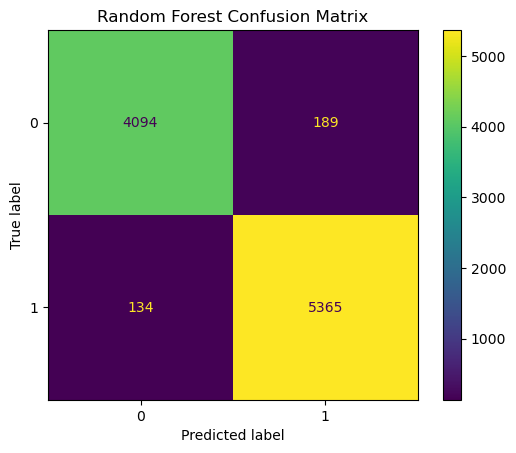

In [49]:
rf_preds = rf_result.best_estimator_.predict(X_test)
rf_f1 = f1_score(y_test,rf_preds)
ConfusionMatrixDisplay(confusion_matrix(y_test, rf_preds)).plot()
plt.grid(False)
plt.title("Random Forest Confusion Matrix")

In [50]:
scores = pd.DataFrame({'model': ['Logistic Regression', 'Decision Tree', 'Bayes','Random Forest'], 
                       'Accuracy Score': [lr_score, dt_score, by_score,rf_score],
                       'Training Score': [lr_train_score, dt_train_score, by_train_score,rf_train_score],
                       'F1': [lr_f1, tree_f1, by_f1,rf_f1],})#.set_index('model')
scores

,model,Accuracy Score,Training Score,F1
0,Logistic Regression,0.984257,0.990458,0.986094
1,Decision Tree,0.981088,0.998466,0.983232
2,Bayes,0.733183,0.727372,0.689803
3,Random Forest,0.966980,0.970761,0.970777


Since F1 scores handle unbalanced distributions of classes to classify better in general, they have been graphed below. It is also acknowleged that because the original distributions for phishing emails in this project were fairly even, there is not a big difference between accuracy and F1 for each model. This would not necessarily be true in a real world context and the distribution of emails an email address receives will vary greatly, and so F1 provides 

F1 was picked over recall and precision since while allowing dangerous email through is definitely more perilous than accidentally blocking legitimate emails, an email filter that blocks too many legitimate emails will soon be abandoned for more lenient ones, thus defeating the point of developing such filter in the first place. As a result, getting as many emails classified correctly as possible is the goal here.

Text(0.5, 1.0, 'F1 of each Model')

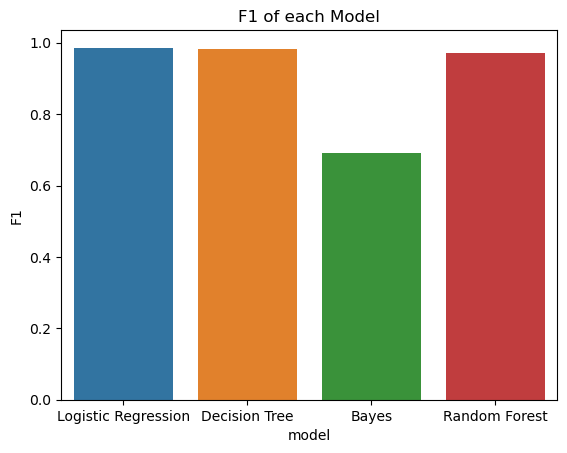

In [52]:
ax = sns.barplot(data = scores, x = 'model',y = 'F1')
ax.set_title('F1 of each Model')

**Conclusion**

Overall, Logistic Regression, Decision Tree, and Random Forest were able to achieve very high levels of accuracy and classify the risk level of each email quite well with minimal data engineering and metadata, such as message length.

Given the decision tree model's tendency to overfit and Random Forest's similar procilvities and taking longer to train, I suspect Logistic Regression would be able to scale far better on new emails and much larger datasets of emails. Meanwhile, Naive Bayes did poorly without the time and usual tools to engineer the data into a form better for its tendencies.

However, based solely on the results of this project alone, it is very much worth further exploring using machine learning and artificial intelligence to catch dangerous phishing emails using various model types, and even simple models provide a lot of predictive power and could help make email inboxes safer for all who use them.

**Future Ideas**

As mentioned above, more data engineering could have been done to level the playing field for the Bayes model since it is otherwise too sensitive to words not appearing in dangerous emails. 
More generally, there are other general rules taught to people to detect A pretrained model on message sentiment evaluating how urgent of a tone an email presents could be used to measure the "urgency" in each email, which is another tactic attackers use in phishing emails to encourage victims to quickly act fast enough to not notice other warning clues in the email. The presence of attachments, which can hide exploit code when opened, was not present in the data used for this project, and so another dataset that does record if the email had an attachment could be used to train a future model to take into account attachment metadata.